In [1]:
# I created a landmark dataset.
# But now i am wondering, if I did data processing, it would mess up the images in the dataset,
# making it unable to identify the landmarks and destroy the training model.
# But I will try to see the result in the end, and the accuracy it has to a similer dataset.
# Then I try to see the model next to my camera.

In [1]:
# import data processing and visualisation libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import skimage
from skimage.transform import resize
from skimage import exposure

import tensorflow as tf
from tensorflow import keras
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Flatten
from tensorflow.keras import datasets, layers, models

import gc


2024-04-18 01:02:33.850117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 01:02:35.027319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 64
imageSize = 64
target_dims = (imageSize, imageSize, 3)
num_classes = 26

def get_data(folder, max_images_per_class=1000):
    X = []
    y = []
    labels = {}
    label_index = 0
    for folderName in sorted(os.listdir(folder)):
        if not folderName.startswith('.'):
            labels[folderName] = label_index
            image_count = 0
            for image_filename in os.listdir(os.path.join(folder, folderName)):
                if image_count >= max_images_per_class:
                    break
                img_file = cv2.imread(os.path.join(folder, folderName, image_filename))
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_file = img_file / 255.0
                    img_file = exposure.equalize_hist(img_file)
                    X.append(img_file)
                    y.append(label_index)
                    image_count += 1
            label_index += 1
    return np.array(X), np.array(y)

train_dir = "./landmarks_mine_dataset/"
X_train, y_train = get_data(train_dir, 1000)

print("Images successfully imported...")


/home/sachithrka/.local/lib/python3.10/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


Images successfully imported...


In [3]:
print("the Shape of x train is : ", X_train.shape)
print("the Shape of y train is : ", y_train.shape)

the Shape of x train is :  (2939, 64, 64, 3)
the Shape of y train is :  (2939,)


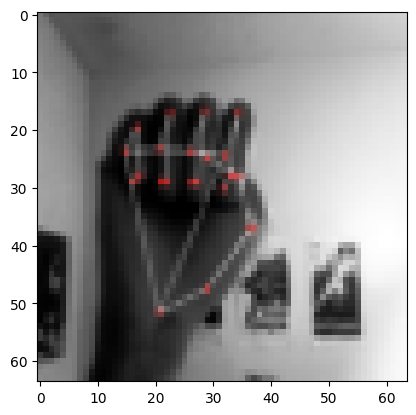

In [4]:
plt.imshow(X_train[0])
plt.show()

In [5]:
# Data Processingtotal
X_data = X_train
y_data = y_train

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3,random_state=42,stratify=y_data)

In [6]:
print(np.max(y_train))
print(num_classes)

2
26


In [7]:
# One-Hot-Encoding the categorical data

num_classes = np.max(y_train) + 1
y_cat_train = to_categorical(y_train, num_classes)
y_cat_test = to_categorical(y_test, num_classes)

In [8]:
# Checking the dimensions of all the variables
print(X_train.shape)
print(X_test.shape)
print(X_test.shape)
print(y_test.shape)
print(y_cat_train.shape)
print(y_cat_test.shape)

(2057, 64, 64, 3)
(882, 64, 64, 3)
(882, 64, 64, 3)
(882,)
(2057, 3)
(882, 3)


In [9]:
# CPU and RAM save

import gc
del X_data
del y_data
gc.collect()

3487

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,238,019 (4.72 MB)

 Trainable params: 1,238,019 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [20]:
history = model.fit(X_train, y_cat_train, 
          epochs=50,
          batch_size=64,
          verbose=2,
          validation_data=(X_test, y_cat_test))

Epoch 1/50


2024-04-18 01:12:00.024076: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 101105664 exceeds 10% of free system memory.


33/33 - 7s - 197ms/step - accuracy: 1.0000 - loss: 1.1316e-04 - val_accuracy: 1.0000 - val_loss: 1.1892e-04
Epoch 2/50
33/33 - 7s - 198ms/step - accuracy: 1.0000 - loss: 9.5644e-05 - val_accuracy: 1.0000 - val_loss: 1.0180e-04
Epoch 3/50
33/33 - 6s - 194ms/step - accuracy: 1.0000 - loss: 8.0876e-05 - val_accuracy: 1.0000 - val_loss: 8.8662e-05
Epoch 4/50
33/33 - 7s - 201ms/step - accuracy: 1.0000 - loss: 7.2015e-05 - val_accuracy: 1.0000 - val_loss: 8.8438e-05
Epoch 5/50
33/33 - 6s - 196ms/step - accuracy: 1.0000 - loss: 7.5137e-05 - val_accuracy: 1.0000 - val_loss: 9.2876e-05
Epoch 6/50
33/33 - 6s - 193ms/step - accuracy: 1.0000 - loss: 6.5423e-05 - val_accuracy: 1.0000 - val_loss: 7.2913e-05
Epoch 7/50
33/33 - 6s - 195ms/step - accuracy: 1.0000 - loss: 4.8393e-05 - val_accuracy: 1.0000 - val_loss: 5.8046e-05
Epoch 8/50
33/33 - 6s - 192ms/step - accuracy: 1.0000 - loss: 4.1629e-05 - val_accuracy: 1.0000 - val_loss: 5.4217e-05
Epoch 9/50
33/33 - 6s - 194ms/step - accuracy: 1.0000 - los

In [21]:
metrics = pd.DataFrame(model.history.history)
metrics

# 11 epochs are the limit for the maximum accuracy

,accuracy,loss,val_accuracy,val_loss
0,1.0,0.000113,1.0,0.000119
1,1.0,0.000096,1.0,0.000102
2,1.0,0.000081,1.0,0.000089
3,1.0,0.000072,1.0,0.000088
4,1.0,0.000075,1.0,0.000093
5,1.0,0.000065,1.0,0.000073
6,1.0,0.000048,1.0,0.000058
7,1.0,0.000042,1.0,0.000054
8,1.0,0.000038,1.0,0.000049
9,1.0,0.000035,1.0,0.000043


28/28 - 1s - 23ms/step - accuracy: 1.0000 - loss: 5.9802e-06


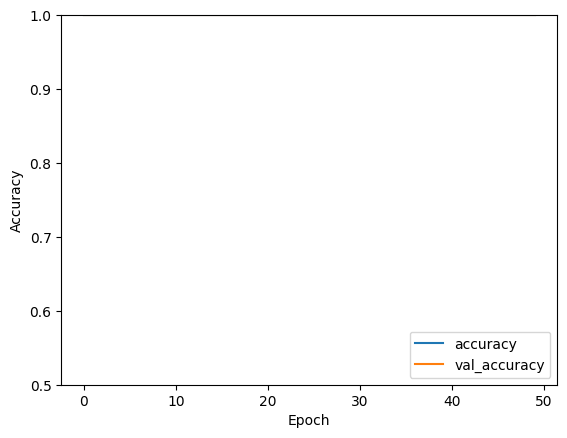

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_cat_test, verbose=2)

In [23]:
print(test_acc)

1.0


In [30]:
train_dir_test = "./landmarks_test_dataset/"
xx_train, yy_train = get_data(train_dir_test)

print("Images successfully imported...")

FileNotFoundError: [Errno 2] No such file or directory: './landmarks_test_dataset/'

In [32]:
from tensorflow.keras.models import load_model

predictions = model.predict(xx_train)

print("Predictions successfully made...")

NameError: name 'xx_train' is not defined

In [33]:
from sklearn.metrics import classification_report
import numpy as np

predictions_class = np.argmax(predictions, axis=1)

print(classification_report(yy_train, predictions_class))

NameError: name 'predictions' is not defined

In [24]:
# Save the model
model.save('asl_landmark_mine_model_one.h5')